# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

## 1. Cargar imágenes

In [41]:
class_names = ['mountain','street','glacier', 'buildings','sea','forest']

#IMAGE_SIZE = (32,32)

In [64]:
IMAGE_WIDTH=32
IMAGE_HEIGHT=32
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
EPOCHS = 10

In [65]:
class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

In [66]:
ROOT_PATH = os.getcwd()

TRAIN_PATH = os.getcwd() + '\\Prof\\data\\seg_train'
TEST_PATH = os.getcwd() + '\\Prof\\data\\seg_test'

In [70]:
def read_data(path, im_size, class_names_label):
    X = []
    y = []

    for folder in os.listdir(path):
        label = class_names_label[folder]
        folder_path = os.path.join(path,folder)
        # Iterar sobre todo lo que haya en path
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path,file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (im_size, im_size))
            X.append(image)
            y.append(label)
    
    
    return np.array(X), np.array(y)
    

X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH, class_names_label)
X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH, class_names_label)

print(X_train.shape)
print(X_test.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)


In [71]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [72]:
y_train

array([3, 1, 1, ..., 2, 3, 0])

## 2. Mostrar imágenes

street


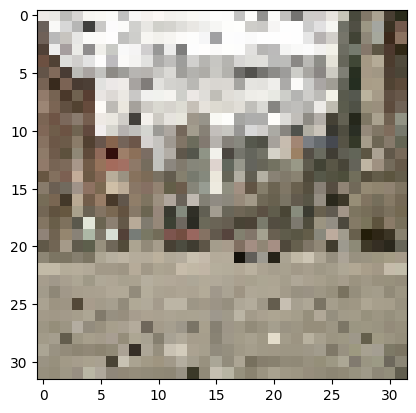

In [73]:
index = np.random.randint(X_train.shape[0])
print(class_names[y_train[index]])
plt.imshow(X_train[index]);

## 3. Normalización

In [74]:
X_train_scal = X_train/255.0
X_test_scal = X_test/255.0

In [116]:
print("Min:", np.min(X_train_scal))
print("Max:", np.max(X_train_scal))

Min: 0.0
Max: 1.0


In [117]:
X_train_scal.shape

(14034, 32, 32, 3)

Guardamos Datos

In [77]:
np.savez(ROOT_PATH + '/data.npz',
        X_train = X_train_scal,
        y_train = y_train,
        X_test = X_test_scal,
        y_test = y_test)

Cargamos Datos

In [78]:
data = np.load(ROOT_PATH + '/data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [104]:
X_train.shape[1]

32

## 4. Diseñar la RRNN

In [60]:
'''
cambio esta variable definda arriba, me da error al intentar ejecutar la estructura de la red. Inicialmente estaba
'''

#IMAGE_SIZE = (32, 32, 3)


'\ncambio esta variable definda arriba, me da error al intentar ejecutar la estructura de la red. Inicialmente estaba\n'

In [106]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(6, activation='softmax') #6 nodos de salida, softmax porque son varias categorias por clasificar, multiclase.
]

model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [107]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 6, 6, 128)         0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 4608)              0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [108]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystop = EarlyStopping(patience=5) #Evita sobreajuste del modelo

In [109]:
mcheckpoint = ModelCheckpoint("callback_model.h5") #Guardamos el modelo

### Entrenamos el modelo

In [110]:
from keras.utils import to_categorical
y_train_categorical = to_categorical(y_train, num_classes=6)

In [114]:
y_train_categorical

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [115]:
history = model.fit(X_train,
         y_train_categorical,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2, 
         verbose=1)

Epoch 1/10
347/351 [============================>.] - ETA: 0s

ValueError: Unexpected result of `train_function` (Empty logs). This could be due to issues in input pipeline that resulted in an empty dataset. Otherwise, please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.